In [1]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum

In [2]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
df_lab = pd.read_csv('Lab-Data.csv', index_col=0) # index_col stops index being read as column
df_turk = pd.read_csv('Turk-Data.csv', index_col=0)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_lab

button      event_type  \
0           1       mousedown   
1           1         mouseup   
2           1           click   
3           1       mousedown   
4           1  mousedirchange   
...       ...             ...   
58280       1           click   
58281       1           click   
58282       1           click   
58283       1           click   
58284       1           click   

                                                  target        time      x  \
0              [id="alloc-slider-return-4"]>svg>g>circle    0.000000  397.0   
1              [id="alloc-slider-return-4"]>svg>g>circle    0.547000  423.0   
2              [id="alloc-slider-return-4"]>svg>g>circle    0.547000  423.0   
3              [id="alloc-slider-return-4"]>svg>g>circle    1.176995  426.0   
4              [id="alloc-slider-return-4"]>svg>g>circle    1.790000  440.0   
...                                                  ...         ...    ...   
58280  [id="portfolio-selection"]>div:nth-child(3)>di...  275.048950  942.0   
58281  [id="portfolio-selection"]>div:nth-child(3)>di...  275.048950  942.0   
58282  [id="portfolio-selection"]>div:nth-child(3)>di...  275.048950  942.0   
58283  [id="portfolio-selection"]>div:nth-child(3)>di...  275.048950  942.0   
58284  [id="portfolio-selection"]>div:nth-child(3)>di...  275.048950  942.0   

            y  step turkId                                        file  
0       647.0     1    ID1  global_sa_sl_both_2017-02-08 12_48_51.json  
1       642.0     1    ID1  global_sa_sl_both_2017-02-08 12_48_51.json  
2       642.0     1    ID1  global_sa_sl_both_2017-02-08 12_48_51.json  
3       642.0     1    ID1  global_sa_sl_both_2017-02-08 12_48_51.json  
4       640.0     1    ID1  global_sa_sl_both_2017-02-08 12_48_51.json  
...       ...   ...    ...                                         ...  
58280  1248.0     1   ID18                      study_results.all.json  
58281  1248.0     2   ID18                      study_results.all.json  
58282  1248.0     3   ID18                      study_results.all.json  
58283  1248.0     4   ID18                      study_results.all.json  
58284  1248.0     5   ID18                      study_results.all.json  

[58285 rows x 9 columns]

# Renaming Targets

Here I will rename the tagets so that theyre more understandable.
First Idea was to look through each unique html element and try to map it to a more human readable name, but there was way to many.
Looking through the data the items were iterested in are "alloc-slider-X" where X is 1,2,3,4,5.
So it was decided to search for any html elements and rename them to "html other".
To do this any recored containing '>' was renamed.


In [5]:
# Before TURK rename
df_turk['target'].value_counts()

alloc-slider-2                                                                                                                                                                                                                                                                                                        170652
alloc-slider-5                                                                                                                                                                                                                                                                                                        155753
alloc-slider-4                                                                                                                                                                                                                                                                                                        153602
html > body > main > div#content > form#portfolio

In [6]:
# RENAME TURKS

# Turk target  might be 
# html > body > main > div#content > form#portfolio-selection
# > div.investment-test > div.portfolio-interface.row > div.stock-selection.large-7.columns 
# > div.stock-allocator.row.valign-middle > div.large-4.columns > div#alloc-slider-return-0.sparkline.narrow.return 
# > svg.chart.control > g > circle.handle
# So pick up on the > and rename
df_turk.loc[df_turk['target'].str.contains('>'), 'target'] = 'html_other'

# See how there are many targets not renamed and their distributions
df_turk['target'].value_counts()

html_other               490349
alloc-slider-2           170652
alloc-slider-5           155753
alloc-slider-4           153602
alloc-slider-1           131002
alloc-slider-3           124736
html                      23808
portfolio-selection       15282
investment-results        12167
portfolio-stats            6039
content                    2713
risk-return                1147
alloc-slider-return-3      1040
alloc-slider-return-1       630
saved-port-0                591
alloc-slider-return-2       470
saved-port-1                445
alloc-slider-risk-1         435
alloc-slider-return-0       426
alloc-slider-risk-3         374
alloc-slider-return-4       328
alloc-slider-risk-4         287
alloc-slider-risk-0         245
alloc-slider-risk-2         201
saved-port-2                196
saved-port-3                 86
saved-port-4                 40
saved-port-5                  9
parsley-id-3644               7
saved-port-6                  6
parsley-id-8124               2
parsley-

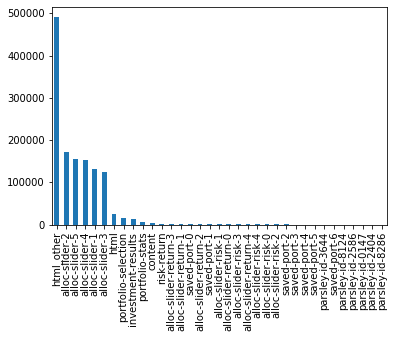

In [7]:
df_turk['target'].value_counts().plot(kind='bar')

In [8]:
# Before LAB rename
df_lab['target'].value_counts()

[id="alloc-slider-return-3"]>svg                                                                            4531
[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(6)>div:nth-child(2)>input    3138
[id="alloc-slider-return-1"]>svg                                                                            2544
[id="alloc-slider-return-4"]>svg                                                                            2399
[id="alloc-slider-return-2"]>svg                                                                            2294
                                                                                                            ... 
[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(8)>div:nth-child(1)             1
[id="portfolio-stats"]>svg>g>g:nth-child(2)>g:nth-child(1)>text                                                1
[id="portfolio-stats"]>svg>g>g:nth-child(2)>g:nth-child(2)>text                                 

In [9]:
# RENAME LABS

# TODO Labs seem to have many more "html_other" elements than TURK. 
# Might have to rename some of the items to make them more even.

# lab target  might be 
# [id="alloc-slider-risk-4"]>svg

# So pick up on the > and rename
df_lab.loc[df_lab['target'].str.contains('>'), 'target'] = 'html_other'

df_lab.to_csv('lab-Data-renamed.csv')   # save changes

# See how there are many targets not renamed and their distributions
df_lab['target'].value_counts()

html_other               49438
alloc-slider-2            2002
alloc-slider-3            1170
alloc-slider-5             902
alloc-slider-4             788
alloc-slider-1             708
portfolio-selection        622
html                       524
alloc-slider-return-3      436
investment-results         258
alloc-slider-risk-1        233
risk-return                175
alloc-slider-return-2      165
alloc-slider-return-0      136
alloc-slider-risk-3        123
alloc-slider-return-1      103
alloc-slider-risk-0        101
saved-port-0                75
survey-container            71
saved-port-1                60
alloc-slider-risk-2         52
content                     41
alloc-slider-risk-4         35
alloc-slider-return-4       29
pretest3                    12
pretest2                     8
pretest4                     6
pretest1                     5
parsley-id-137               4
saved-port-6                 3
Name: target, dtype: int64

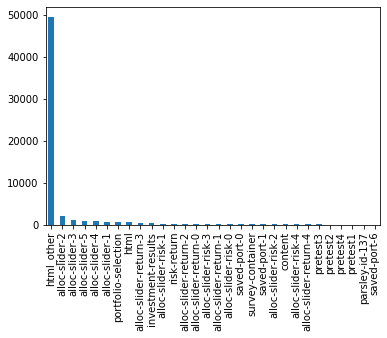

In [10]:
# Comparing this plot for lab values compared to the turk values we can see that html other has a much higher proportion of the targets.
# If we look at the value counts before renaming we can see that the most frequent item is [id="alloc-slider-return-3"]>svg.
# I will rename html elements like [id="alloc-slider-return-3"]>svg to alloc-slider-3.
# Goal is to make the distributions of values for the 2 categories look more similar.
# Other analysis for this project so far has shown that the lab and turk datas cannot be easily identified with number of mouse events,
# therefore I would expect the distribution of sliders to look very similar.

df_lab['target'].value_counts().plot(kind='bar')

In [11]:
# Rename LAB data 
# rename some html elemets to alloc-slider-X

# Reload df_lab as original unaltered data
df_lab = pd.read_csv('Lab-Data.csv', index_col=0)

df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-0'), 'target'] = 'alloc-slider-0'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-1'), 'target'] = 'alloc-slider-1'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-2'), 'target'] = 'alloc-slider-2'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-3'), 'target'] = 'alloc-slider-3'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-4'), 'target'] = 'alloc-slider-4'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-return-5'), 'target'] = 'alloc-slider-5'

df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-0'), 'target'] = 'alloc-slider-0'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-1'), 'target'] = 'alloc-slider-1'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-2'), 'target'] = 'alloc-slider-2'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-3'), 'target'] = 'alloc-slider-3'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-4'), 'target'] = 'alloc-slider-4'
df_lab.loc[df_lab['target'].str.contains('alloc-slider-risk-5'), 'target'] = 'alloc-slider-5'



# Now sliders are renamed we can deal with the other html elements

df_lab.loc[df_lab['target'].str.contains('>'), 'target'] = 'html_other'

df_lab['target'].value_counts()

html_other             17325
alloc-slider-3          9777
alloc-slider-2          8686
alloc-slider-1          7253
alloc-slider-4          7147
alloc-slider-0          5331
alloc-slider-5           902
portfolio-selection      622
html                     524
investment-results       258
risk-return              175
saved-port-0              75
survey-container          71
saved-port-1              60
content                   41
pretest3                  12
pretest2                   8
pretest4                   6
pretest1                   5
parsley-id-137             4
saved-port-6               3
Name: target, dtype: int64

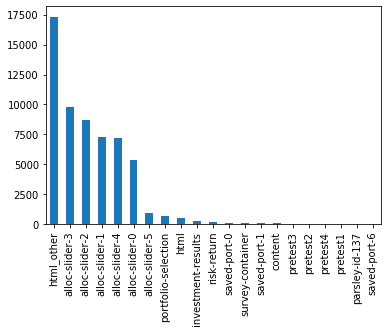

In [12]:
df_lab['target'].value_counts().plot(kind = 'bar')

In [13]:
# See if we can improve on the turk data by renaming more targets

# Rename turk data 
# rename some html elemets to alloc-slider-X

# Reload df_turk as original unaltered data
df_turk = pd.read_csv('turk-Data.csv', index_col=0)

df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-0'), 'target'] = 'alloc-slider-0'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-1'), 'target'] = 'alloc-slider-1'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-2'), 'target'] = 'alloc-slider-2'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-3'), 'target'] = 'alloc-slider-3'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-4'), 'target'] = 'alloc-slider-4'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-return-5'), 'target'] = 'alloc-slider-5'

df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-0'), 'target'] = 'alloc-slider-0'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-1'), 'target'] = 'alloc-slider-1'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-2'), 'target'] = 'alloc-slider-2'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-3'), 'target'] = 'alloc-slider-3'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-4'), 'target'] = 'alloc-slider-4'
df_turk.loc[df_turk['target'].str.contains('alloc-slider-risk-5'), 'target'] = 'alloc-slider-5'



# Now sliders are renamed we can deal with the other html elements

df_turk.loc[df_turk['target'].str.contains('>'), 'target'] = 'html_other'

df_turk['target'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


html_other             407179
alloc-slider-2         188453
alloc-slider-4         175307
alloc-slider-5         155753
alloc-slider-1         150480
alloc-slider-3         140894
html                    23808
portfolio-selection     15282
alloc-slider-0          12464
investment-results      12167
portfolio-stats          6039
content                  2713
risk-return              1147
saved-port-0              591
saved-port-1              445
saved-port-2              196
saved-port-3               86
saved-port-4               40
saved-port-5                9
parsley-id-3644             7
saved-port-6                6
parsley-id-8124             2
parsley-id-2586             2
parsley-id-8286             1
parsley-id-2404             1
parsley-id-0147             1
Name: target, dtype: int64

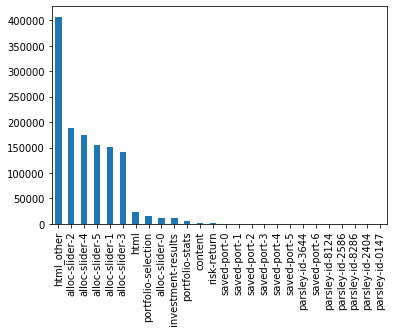

In [14]:
# This plot now looks perfect
# Now the distributions for the lab and turk look very similar, with the most frequent target being approximately half as common as html other.

df_turk['target'].value_counts().plot(kind = 'bar')

In [15]:
# Save the new renamed data
df_turk.to_csv('turk-Data-renamed.csv')
df_lab.to_csv('lab-Data-renamed.csv')

In [16]:
# load them back in.
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)


In [17]:

def calculate_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_ngrams = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        all_ngrams.extend(common_ngrams)

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # Sum the frequencies of similar ngrams.
    df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))
    return df_ngrams.reset_index(drop=True)

# NOTE: This wont take into account outliers. 
# Say if noone touched slider 2 other than 1 user, we would still say slider 2 was very frequent event if it was only 1 user.



In [18]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams.head())
turk_unigrams = calculate_ngrams(df_turk, 1)
print(turk_unigrams.head())


n-grams  Frequency  Relative Frequency
0      html_other      17325          962.500000
1  alloc-slider-3       9777          543.166667
2  alloc-slider-2       8686          482.555556
3  alloc-slider-1       7253          402.944444
4  alloc-slider-4       7147          397.055556
          n-grams  Frequency  Relative Frequency
0      html_other     407179          883.251627
1  alloc-slider-2     188453          408.791757
2  alloc-slider-4     175307          380.275488
3  alloc-slider-5     155753          337.859002
4  alloc-slider-1     150480          326.420824


In [19]:
lab_unigrams['n-grams'][1]

'alloc-slider-3'

In [20]:
turk_unigrams['n-grams'][1] == lab_unigrams['n-grams'][1]

False

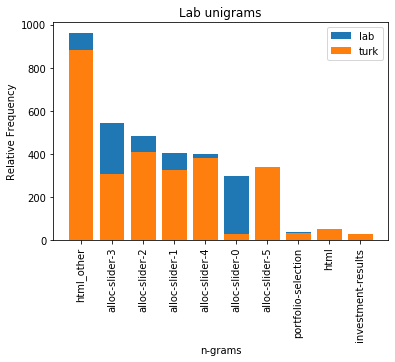

In [21]:
plt.bar(lab_unigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_unigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

labels = df_lab['target'].value_counts()[:20]    # Get first 20 most frequent items
labels = labels.index.to_list()   # items to list


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab unigrams")
plt.legend(loc='best')

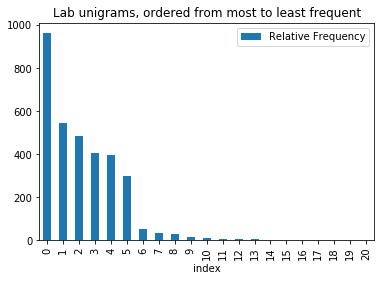

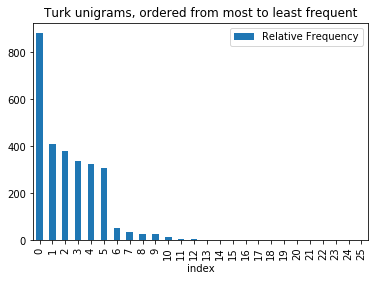

In [22]:
# These plots show the frequency of different unique n-grams in Lab and Turk data.
# I can see that anything after the 10th most frequent item contains almost no occurances so it can be removed.

lab_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Lab unigrams, ordered from most to least frequent')
turk_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Turk unigrams, ordered from most to least frequent')

n-grams  Frequency  Relative Frequency
0            html_other      17325          962.500000
1        alloc-slider-3       9777          543.166667
2        alloc-slider-2       8686          482.555556
3        alloc-slider-1       7253          402.944444
4        alloc-slider-4       7147          397.055556
5        alloc-slider-0       5331          296.166667
6        alloc-slider-5        902           50.111111
7   portfolio-selection        622           34.555556
8                  html        524           29.111111
9    investment-results        258           14.333333
10          risk-return        175            9.722222
11         saved-port-0         75            4.166667
12     survey-container         71            3.944444
13         saved-port-1         60            3.333333
14              content         41            2.277778
15             pretest3         12            0.666667
16             pretest2          8            0.444444
17             pretest4          6            0.333333
18             pretest1          5            0.277778
19       parsley-id-137          4            0.222222
20         saved-port-6          3            0.166667

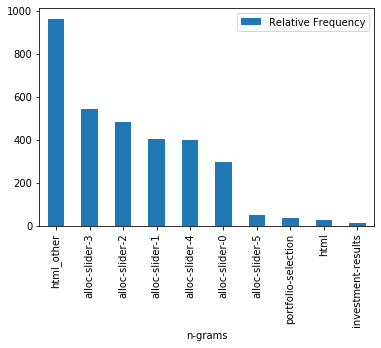

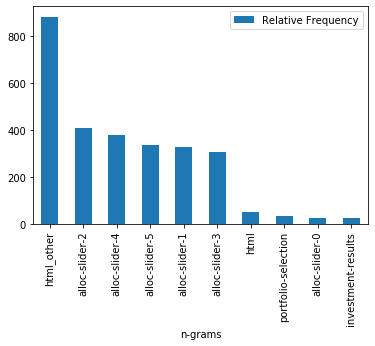

In [23]:
lab_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')
turk_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')

# Create these plots but with a breakdown in each column showing what ID it came from.
# This will help us identidy any outliers, and remove them if they are skewing the resutls.
# TODO create a stacked bar chart in tableau by adding column to n-grams dataframe of ID.

lab_unigrams

Now we've done some exploration into unigrams, lets look at tri-grams to see if theres anything interesting going on.


In [24]:
lab_trigrams = calculate_ngrams(df_lab, 3)
turk_trigrams = calculate_ngrams(df_turk, 3)

print(lab_trigrams.head())
print(turk_trigrams.head())

n-grams  Frequency  \
0              html_other : html_other : html_other      16535   
1  alloc-slider-3 : alloc-slider-3 : alloc-slider-3       9253   
2  alloc-slider-2 : alloc-slider-2 : alloc-slider-2       8124   
3  alloc-slider-1 : alloc-slider-1 : alloc-slider-1       6750   
4  alloc-slider-4 : alloc-slider-4 : alloc-slider-4       6671   

   Relative Frequency  
0          918.611111  
1          514.055556  
2          451.333333  
3          375.000000  
4          370.611111  
                                            n-grams  Frequency  \
0              html_other : html_other : html_other     379818   
1  alloc-slider-2 : alloc-slider-2 : alloc-slider-2     176185   
2  alloc-slider-4 : alloc-slider-4 : alloc-slider-4     163671   
3  alloc-slider-5 : alloc-slider-5 : alloc-slider-5     147588   
4  alloc-slider-1 : alloc-slider-1 : alloc-slider-1     141601   

   Relative Frequency  
0          823.900217  
1          382.180043  
2          355.034707  
3         

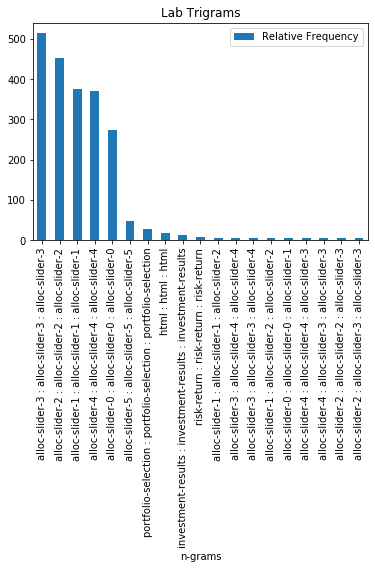

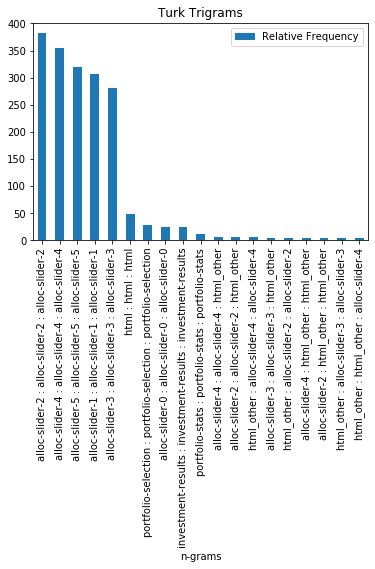

In [25]:
#[1:20] hides the first result which is much more frequent and hides everything else
lab_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Lab Trigrams')
turk_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Turk Trigrams')

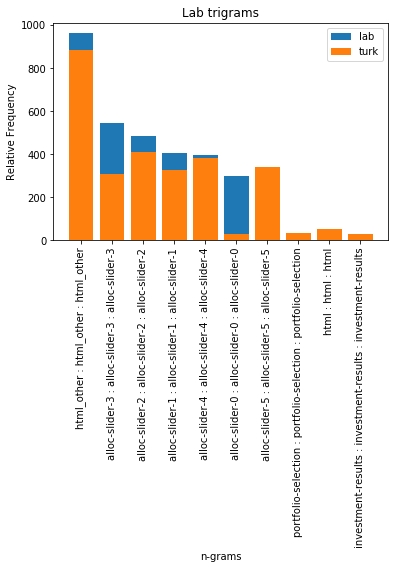

In [26]:
plt.bar(lab_trigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_trigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

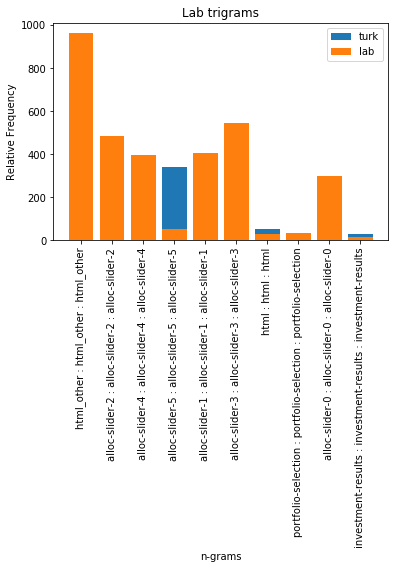

In [27]:
plt.bar(turk_trigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')
plt.bar(lab_trigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

In [28]:
turk_trigrams

n-grams  Frequency  \
0                 html_other : html_other : html_other     379818   
1     alloc-slider-2 : alloc-slider-2 : alloc-slider-2     176185   
2     alloc-slider-4 : alloc-slider-4 : alloc-slider-4     163671   
3     alloc-slider-5 : alloc-slider-5 : alloc-slider-5     147588   
4     alloc-slider-1 : alloc-slider-1 : alloc-slider-1     141601   
..                                                 ...        ...   
753             content : investment-results : content          1   
754  portfolio-selection : html_other : alloc-slider-2          1   
755  portfolio-selection : html_other : alloc-slider-4          1   
756            portfolio-selection : html_other : html          1   
757      alloc-slider-3 : html_other : parsley-id-0147          1   

     Relative Frequency  
0            823.900217  
1            382.180043  
2            355.034707  
3            320.147505  
4            307.160521  
..                  ...  
753            0.002169  
754            0.002169  
755            0.002169  
756            0.002169  
757            0.002169  

[758 rows x 3 columns]

Maybe bi-grams will be better to use

n-grams  Frequency  Relative Frequency
0          html_other : html_other      16899          938.833333
1  alloc-slider-3 : alloc-slider-3       9510          528.333333
2  alloc-slider-2 : alloc-slider-2       8400          466.666667
3  alloc-slider-1 : alloc-slider-1       6990          388.333333
4  alloc-slider-4 : alloc-slider-4       6904          383.555556
                           n-grams  Frequency  Relative Frequency
0          html_other : html_other     392480          851.366594
1  alloc-slider-2 : alloc-slider-2     182186          395.197397
2  alloc-slider-4 : alloc-slider-4     169353          367.360087
3  alloc-slider-5 : alloc-slider-5     151582          328.811280
4  alloc-slider-1 : alloc-slider-1     145971          316.639913


n-grams  Frequency  Relative Frequency
0            html_other : html_other     392480          851.366594
1    alloc-slider-2 : alloc-slider-2     182186          395.197397
2    alloc-slider-4 : alloc-slider-4     169353          367.360087
3    alloc-slider-5 : alloc-slider-5     151582          328.811280
4    alloc-slider-1 : alloc-slider-1     145971          316.639913
..                               ...        ...                 ...
228    saved-port-0 : alloc-slider-2          1            0.002169
229    saved-port-0 : alloc-slider-3          1            0.002169
230    alloc-slider-3 : saved-port-4          1            0.002169
231    alloc-slider-3 : saved-port-3          1            0.002169
232     html_other : parsley-id-2404          1            0.002169

[233 rows x 3 columns]

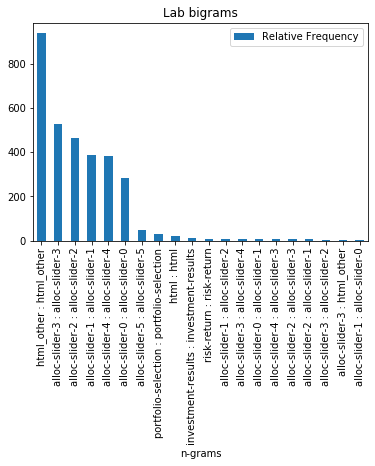

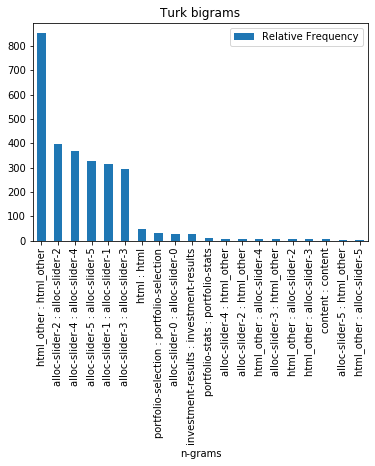

In [29]:
lab_bigrams = calculate_ngrams(df_lab, 2)
turk_bigrams = calculate_ngrams(df_turk, 2)

print(lab_bigrams.head())
print(turk_bigrams.head())

lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams')
turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

turk_bigrams

(<matplotlib.axes._subplots.AxesSubplot at 0x19e826e7d48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19e824af788>)

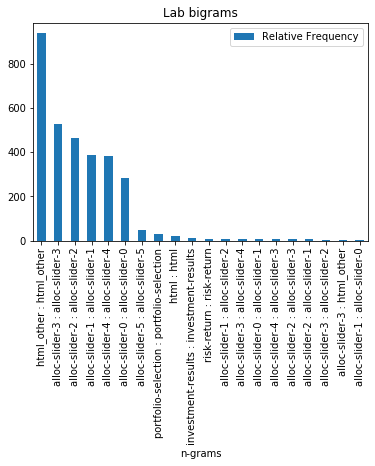

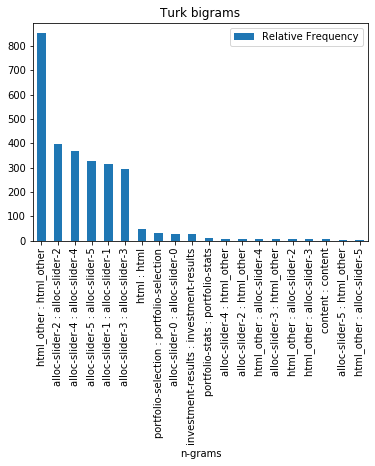

In [30]:
lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams'),turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

# New idea

Now we know what the average turk and lab data distribution looks like for unigrams, bigrams, and trigrams.
Next I need to make a function that will return the count of each different gram for EACH INDIVIDUAL.
Then I can compare the counts of these people the counts of the average.

TODO: Do a scatterplot where the x-axis is the the different ngrams and the y axis is count of ngrams for each individual. Each users datapoint will be a different colour x.

After this maybe try with different ngrams being different axis or something.

In [58]:
def calculate_users_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_users_ngram_counts = []
    all_users_ID = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        all_users_ngram_counts.extend(common_ngrams)

        # TODO Change so we append everything as a list and then turn everything into a dataframe outside the loop to massively improve effecienncy

        # Add users ID as a new column
        ID_column = [ID] * len(common_ngrams)
        all_users_ID.extend(ID_column)

    #print(len(all_users_ngram_counts[0][5]))

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_users_ngram_counts, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users

    # Add ID column
    df_ngrams['ID'] = all_users_ID

    return df_ngrams

lab_users_unigrams = calculate_users_ngrams(df_lab, 1)
turk_users_unigrams = calculate_users_ngrams(df_turk, 1)

In [59]:
lab_users_unigrams

n-grams  Frequency    ID
0    alloc-slider-2        755   ID1
1    alloc-slider-0        739   ID1
2    alloc-slider-1        624   ID1
3    alloc-slider-4        594   ID1
4    alloc-slider-3        266   ID1
..              ...        ...   ...
132  alloc-slider-4        394  ID18
133  alloc-slider-1        354  ID18
134      html_other         96  ID18
135     risk-return          3  ID18
136    saved-port-1          3  ID18

[137 rows x 3 columns]

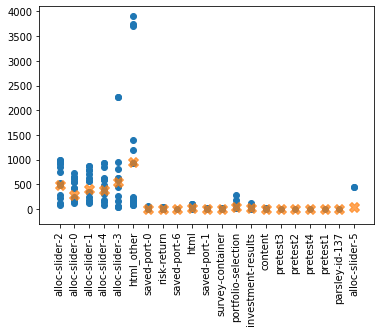

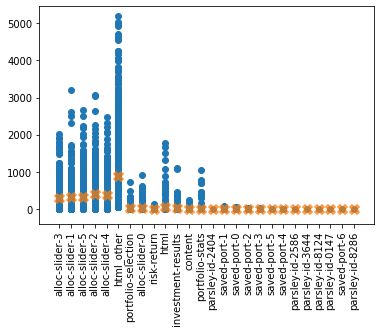

In [60]:
plt.scatter(lab_users_unigrams['n-grams'], lab_users_unigrams['Frequency'] )
plt.scatter(lab_unigrams['n-grams'], lab_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_unigrams['n-grams'], turk_users_unigrams['Frequency'] )
plt.scatter(turk_unigrams['n-grams'], turk_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [61]:
lab_users_bigrams = calculate_users_ngrams(df_lab, 2)
turk_users_bigrams = calculate_users_ngrams(df_turk, 2)

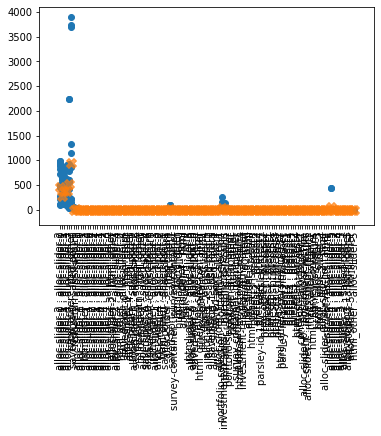

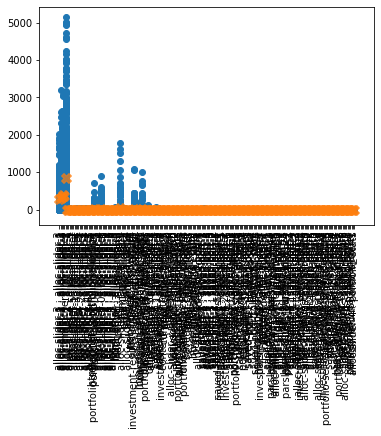

In [62]:

plt.scatter(lab_users_bigrams['n-grams'], lab_users_bigrams['Frequency'] )
plt.scatter(lab_bigrams['n-grams'], lab_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_bigrams['n-grams'], turk_users_bigrams['Frequency'] )
plt.scatter(turk_bigrams['n-grams'], turk_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [63]:
# TODO: Plot the 'average' values for the distribution of these points on the same chart.


# Here they suggest bayes filtering can be used to detect language, maybe I use too?
https://stackoverflow.com/questions/101569/algorithm-to-detect-similar-documents-in-python-script

# Naive Bayes
Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
Could even use this to get the counts of 2/3-grams to compare?
https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

TODO: I think for any of these to be used we would have to properly rename all the mouse items so they match

In [64]:
# Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
# Could even use this to get the counts of 2/3-grams to compare?
# https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB



In [65]:
x = df_lab[ df_lab['turkId'] == 'ID1' ] ['target']
x[2]

# Converts the rows of targets to a single string, seperated by commas
IDs = df_lab['turkId'].unique()
targets_text = []

for ID in IDs:
    targets_series = df_lab[ df_lab['turkId'] == ID ] ['target']
    targets =  ', '.join(targets_series)
    targets_text.append( targets)
    #targets_text = targets

targets_text


ider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-2, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, alloc-slider-5, 

In [66]:
x = df_lab[ df_lab['turkId'] == 'ID3' ] ['target']
', '.join(x)
targets_text[1]

1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-0, alloc-slider-1, alloc-slider-1, alloc-slider-1, alloc

In [67]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ', '.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )


In [68]:
# Append targets and labels
X = np.append(turk_targets, lab_targets)

y = np.append(turk_labels, lab_labels)

In [69]:
len(lab_targets)

18

In [70]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [71]:
#Explore CountVecotrizer

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)
p = counts.toarray()

In [72]:
p

array([[   0,    0,    0, ..., 1009,    0,    0],
       [   0,    0,    0, ..., 3148,    0,    0],
       [   0,    0,    0, ..., 4631,    0,    0],
       ...,
       [   0,    0,    0, ..., 2322,    0,    0],
       [   0,    0,    0, ..., 1955,    0,    0],
       [   0,    0,    0, ..., 2820,    0,    0]], dtype=int64)

In [73]:
# Instantiating Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [74]:
example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)
predictions

array([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [75]:
from sklearn.metrics import accuracy_score

print( accuracy_score(y_test, predictions) )

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)



0.4


array([[47, 71],
       [ 1,  1]], dtype=int64)

Accuracy score: 0.4
[[47 71]
 [ 1  1]]


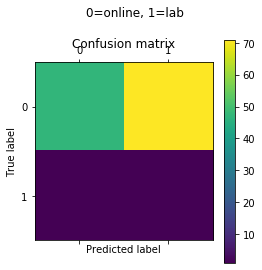

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )

# High accuracy because of imbalenced classes 
# https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/
# This website has some nice references about imblaenced class distributions. TODO: use in diss.
# data sampling – customized algorithms– cost sensitive algorithms– one class algorithms – threshold moving – probability calibration


# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# Better ways of dealing with imbalenced data

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [84]:
# Above has too much online data so there are uneven classes.
# Look at only the first X (20 or so) online data for training

#X_train, X_test, y_train, y_test = train_test_split(X, y)

# TODO: make classes balenced

lab_length = len(lab_targets)

X_balanced = np.append( turk_targets[ :lab_length ] , lab_targets)

y_balanced = np.append(turk_labels[ :lab_length ], lab_labels)

print(f'Length of lab and turk data: {len(X_balanced)}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
cm = confusion_matrix(y_test, predictions)
print(cm)


Length of lab and turk data: 36
Accuracy score: 0.4444444444444444
[[3 2]
 [3 1]]


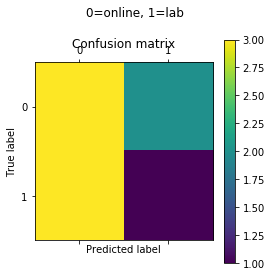

In [85]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [86]:
len(turk_labels)

461

In [87]:
#TODO: https://medium.com/@a.ydobon/justforfunpython-n-gram-to-quantify-similarity-between-sentences-2d61e68a478c
# Use this method to compare one users targets with the rest of their class to get a similarity.
# Then can get the average similarity compared to the group of each target.
# Then compare similarity to other group e.g. how similar is this turk to a lab person.
# If any turk matches lab more then we boldly assume it belongs in the wrong class.

# This funciton works perfectly, its the other function that doesnt work properly lol.
def lists_similarity(list_a, list_b):
    # Calculates siilarity of list_a to list_b
    # Given 2 lists of ngrams, return how 'similar' lists are
    # Similarity is number of matching items / length of list a
    
    similar_count = 0
    common=[]

    for item_a in list_a:
        for item_b in list_b:
            if item_a == item_b:
                #print('MATCH')
                similar_count += 1
                common.append(item_a)


    #print('similar_count', similar_count)
    #print('len(list_a)', len(list_a))
    #print('len(list_b)', len(list_b))
    similarity = similar_count/len(list_a)
    return similarity#,common
    

In [88]:
def compare_all(dataframe, n):
    IDs = dataframe['turkId'].unique()

    # First get a list of all the ngrams for each user in the dataframe
    users_ngrams_list = []

    for ID in IDs:
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)  # creates ngram generator, can be used to find ngrams
        ngrams_list = list(ngrams_generator)        # generator to list
        
        users_ngrams_list.append(ngrams_list)

    #users_ngrams_list # this is a list of lists. index 0 has a list of ngrams from the first user ID.


    # FIrst enumerates, a and b are essesnally a list of the unique users that we go through.
    # After that loop we index into the list, which contains a list of the ngrams of the user with that index
    # e.g. index 0 stores the ngrams about the first user at IDs[0]

    resutls = []    # results should end up being same length as num of IDs

    for index_a, ngrams_list_a in enumerate(users_ngrams_list):
        print(f'ID:{index_a} out of {len(users_ngrams_list)}')

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)

        total_similarity = 0
        for index_b, ngrams_list_b in enumerate(users_ngrams_list):
            # compare list index_a's ngrams with list index_b's

            # we dont want to compare a list to itself for similarity
            if index_a != index_b:
                total_similarity += lists_similarity(ngrams_list_a, ngrams_list_b)

        #print('total_similarity', total_similarity)
        similarity_average = total_similarity/len(IDs)
        #print(f'{index_a} average similarity : {similarity_average}')
        resutls.append(similarity_average)

        #print('similarity_average', similarity_average)

    return pd.DataFrame( {'ID': IDs, 'Similarity': resutls} )

lab_sim = compare_all(df_lab, 2)
#turk_sim = compare_all(df_turk, 2) # start time 15:36

ID:0 out of 18
Current Time = 20:03:03
ID:1 out of 18
Current Time = 20:03:14


KeyboardInterrupt: 

In [0]:
lab_sim

In [0]:
turk_sim.to_csv('turk_sim.csv') # Save as this took AGES to run
turk_sim.plot(kind='bar')